In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from zipfile import ZipFile
import datetime

In [2]:
import matplotlib.pyplot as plt

In [3]:
file="trans_simulated.zip"

In [4]:
fname = 'transaction_data_v4.csv'

In [5]:
archive = ZipFile(file, 'r')

In [6]:
for finfo in archive.infolist():
    print(finfo)

<ZipInfo filename='transaction_data_v4.csv' compress_type=deflate filemode='-rw-rw-r--' file_size=102826571 compress_size=6332475>


In [7]:
df = pd.read_csv(archive.open(fname), encoding = "ISO-8859-1", parse_dates=['txn_date'])

In [8]:
df.shape

(1048575, 9)

In [9]:
df.head()

,customerId,MCC,local_amount,finalmerchid,cleaned_merchant_name,cleaned_merchant_name.1,city,country,txn_date
0,B01A04153D,5462,23,300034089,Jumbo Seafood Riverside,Jumbo Seafood Riverside,Singapore,Singapore,2016-10-01
1,B01A02172D,5462,33,300034089,Jumbo Seafood Riverside,Jumbo Seafood Riverside,Singapore,Singapore,2016-01-20
2,B01A06504D,5462,25,300034089,Jumbo Seafood Riverside,Jumbo Seafood Riverside,Singapore,Singapore,2016-01-20
3,B02A01824D,5462,108,300034089,Jumbo Seafood Riverside,Jumbo Seafood Riverside,Singapore,Singapore,2016-01-15
4,B02A05662D,5462,9,300034089,Jumbo Seafood Riverside,Jumbo Seafood Riverside,Singapore,Singapore,2016-01-13


In [10]:
NOW = datetime.datetime.now()

In [11]:
rfmTable = df.groupby('customerId').agg({"local_amount":np.sum, 
                                         "finalmerchid":'count', 
                                         "txn_date":lambda x: (NOW - x.max()).days})

In [12]:
rfmTable.head()

,local_amount,finalmerchid,txn_date
customerId,,,
B01A00001D,8662,57,1002
B01A00002D,1946,33,960
B01A00003D,1364,32,961
B01A00004D,4656,36,972
B01A00005D,3054,34,964


In [13]:
rfmTable.rename(columns={'txn_date': 'recency', 
                         'finalmerchid': 'frequency', 
                         'local_amount': 'monetary_value'}, inplace=True)

In [14]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [15]:
segmented_rfm = rfmTable

In [16]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [17]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

In [18]:
segmented_rfm.head()

,monetary_value,frequency,recency,r_quartile,f_quartile,m_quartile
customerId,,,,,,
B01A00001D,8662,57,1002,4,1,1
B01A00002D,1946,33,960,1,1,2
B01A00003D,1364,32,961,1,1,3
B01A00004D,4656,36,972,2,1,1
B01A00005D,3054,34,964,1,1,2


In [19]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)

In [20]:
segmented_rfm.head()

,monetary_value,frequency,recency,r_quartile,f_quartile,m_quartile,RFMScore
customerId,,,,,,,
B01A00001D,8662,57,1002,4,1,1,411
B01A00002D,1946,33,960,1,1,2,112
B01A00003D,1364,32,961,1,1,3,113
B01A00004D,4656,36,972,2,1,1,211
B01A00005D,3054,34,964,1,1,2,112


In [21]:
rfm_agg = segmented_rfm.groupby('RFMScore').agg({"monetary_value":np.sum, "frequency":np.sum, "recency":np.mean})

In [22]:
rfm_agg.sort_values(by="monetary_value", ascending=False, inplace=True)
top_15 = rfm_agg

In [23]:
top_15 = top_15.reset_index()

In [56]:
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots(figsize=(20,5))
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        if i%3 ==0:
            ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

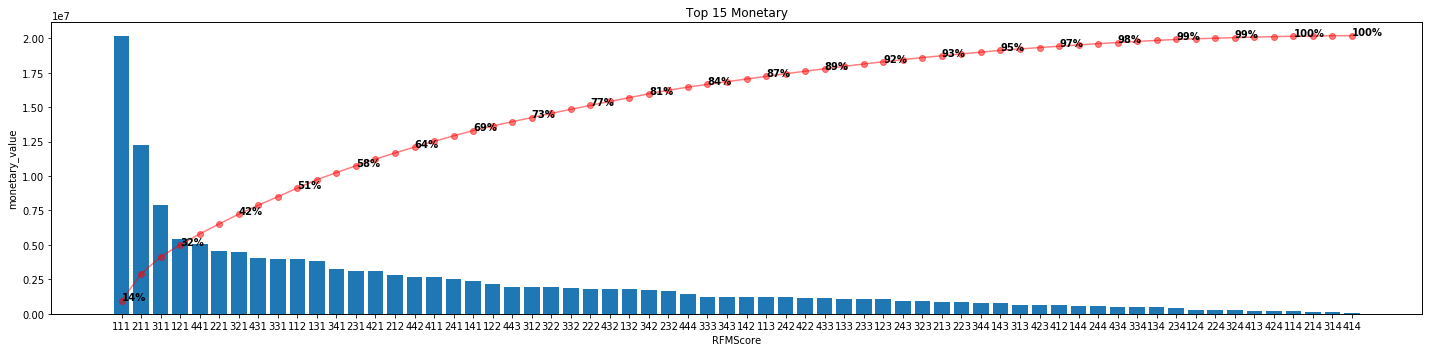

In [57]:
pareto_plot(top_15, x='RFMScore', y='monetary_value', title='Top 15 Monetary')

In [26]:
profitable = ['111', '211', '311', '121', '441', '221', '321']

In [27]:
segmented_rfm['profitable'] = 0

In [28]:
segmented_rfm.loc[segmented_rfm['RFMScore'].isin(profitable), 'profitable'] = 1

In [29]:
segmented_rfm.profitable.value_counts()

0    41730
1     8240
Name: profitable, dtype: int64

In [30]:
segmented_rfm.head()

,monetary_value,frequency,recency,r_quartile,f_quartile,m_quartile,RFMScore,profitable
customerId,,,,,,,,
B01A00001D,8662,57,1002,4,1,1,411,0
B01A00002D,1946,33,960,1,1,2,112,0
B01A00003D,1364,32,961,1,1,3,113,0
B01A00004D,4656,36,972,2,1,1,211,1
B01A00005D,3054,34,964,1,1,2,112,0


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = segmented_rfm[['monetary_value', 'frequency', 'recency']]
y = segmented_rfm['profitable']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [34]:
list(X_train.columns)

['monetary_value', 'frequency', 'recency']

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [36]:
# shape of the dataset
print('Shape of training data :',X_train.shape)
print('Shape of testing data :',X_test.shape)

Shape of training data : (37477, 3)
Shape of testing data : (12493, 3)


In [37]:
model = DecisionTreeClassifier()


In [38]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
print('Depth of the Decision Tree :', model.get_depth())

Depth of the Decision Tree : 4


In [40]:
predict_train = model.predict(X_train)

In [41]:
print('Target on train data',predict_train) 

Target on train data [0 0 0 ... 0 0 0]


In [42]:
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

accuracy_score on train dataset :  1.0


In [43]:
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

Target on test data [0 0 0 ... 0 0 0]


In [44]:
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  1.0


In [45]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/home/crayondata.com/sundararaman/venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [46]:
dot_data = StringIO()

In [47]:
dot_data = export_graphviz(model, out_file=None,  
                filled=True, rounded=True,
                special_characters=True,
                proportion = False, precision = 2,
                feature_names=list(X_train.columns))

In [48]:
print(dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label=<monetary_value &le; 3375.5<br/>gini = 0.28<br/>samples = 37477<br/>value = [31297, 6180]>, fillcolor="#ea9a60"] ;
1 [label=<gini = 0.0<br/>samples = 28086<br/>value = [28086, 0]>, fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<frequency &le; 18.5<br/>gini = 0.45<br/>samples = 9391<br/>value = [3211, 6180]>, fillcolor="#a0d0f3"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label=<recency &le; 990.5<br/>gini = 0.3<br/>samples = 3178<br/>value = [2601, 577]>, fillcolor="#eb9d65"] ;
2 -> 3 ;
4 [label=<gini = 0.0<br/>samples = 2182<br/>value = [2182, 0]>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<frequency &le; 14.5<br/>gini = 0.49<br/>samples = 996<br/>value = [419, 577]>, fillcolor="#c9e4f8"] ;
3 -> 5 ;
6 [label=<gini = 0.0<br/>samples = 577<br/>value = [0, 577]>, fillcolor="#399de5"] ;
5

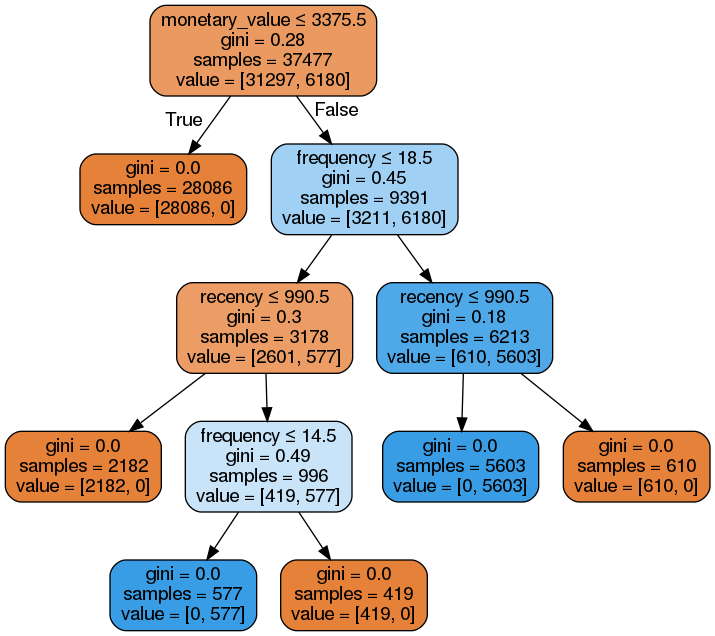

In [49]:
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())